In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader
import geodatasets
import xarray as xr
import numpy as np
from geopandas import GeoSeries
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import Point , Polygon, MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.wkt
import shapely.geometry
import shapely
from shapely.ops import nearest_points
from pathlib import Path
import rasterio
import rioxarray

In [2]:
### First I try to create buffer area regarding criterions of suitabilit index ### 
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]
xr_landuse = xr.open_dataset("Data//dataset-satellite-land-cover//C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2022-01-01')
xr_landuse = xr_landuse.drop_vars('time')
lccs_resolution = 300 ## meters

## only wetland area ## 
xr_landuse['wetland'] = xr.where((xr_landuse['lccs_class'].isin([180,210])),1,0)
df_landuse_wetland = xr_landuse['wetland'].to_dataframe()
df_landuse_wetland.reset_index(inplace=True)

df_landuse_wetland = gpd.GeoDataFrame(df_landuse_wetland, geometry =gpd.points_from_xy(df_landuse_wetland['lon'],df_landuse_wetland['lat']))
df_landuse_wetland.crs = {'init': 'epsg:4326'}
df_landuse_wetland = df_landuse_wetland.to_crs({'init': 'epsg:3857'})

df_landuse_distancetowetland = df_landuse_wetland
df_landuse_wetland = df_landuse_wetland.loc[df_landuse_wetland['wetland'] == 1]


## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.to_crs({'init': 'epsg:3857'})
boundaries = boundaries.geometry.unary_union

## I filter out area outside of THailand ## 
df_landuse_wetland = df_landuse_wetland.loc[df_landuse_wetland.within(boundaries)]
df_landuse_wetland.reset_index(inplace=True,drop=True)


df_distancetowetland = gpd.sjoin_nearest(df_landuse_distancetowetland,df_landuse_wetland,distance_col="distance",how='left')

print(df_distancetowetland.columns)
for i in df_distancetowetland.columns:
    if i not in (['lon_left','lat_left','wetland_left','distance','geometry']):
        df_distancetowetland = df_distancetowetland.drop(columns=i)

df_distancetowetland = df_distancetowetland.rename(columns= {'lon_left' : 'lon'})
df_distancetowetland = df_distancetowetland.rename(columns= {'lat_left' : 'lat'})
df_distancetowetland = df_distancetowetland.rename(columns= {'wetland_left' : 'SI_DtoWetland'})

df_distancetowetland.reset_index(inplace=True,drop=True)
try: 
    df_distancetowetland = df_distancetowetland.drop(columns=['geometry'])
except:
    None

print(df_distancetowetland.columns)
df_distancetowetland = df_distancetowetland.groupby(['lat', 'lon']).agg('mean')
df_distancetowetland.reset_index(inplace=True)
df_distancetowetland = df_distancetowetland.set_index(['lat', 'lon'])
print(df_distancetowetland)

xr_distancetowetland = xr.Dataset.from_dataframe(df_distancetowetland)
print(xr_distancetowetland)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the prefe

Index(['lat_left', 'lon_left', 'wetland_left', 'geometry', 'index_right',
       'lat_right', 'lon_right', 'wetland_right', 'distance'],
      dtype='object')
Index(['lat', 'lon', 'SI_DtoWetland', 'distance'], dtype='object')
                      SI_DtoWetland       distance
lat       lon                                     
5.615278  97.345833             1.0  268609.717907
          97.348611             1.0  268482.427798
          97.351389             1.0  268355.433619
          97.354167             1.0  268228.735792
          97.356944             1.0  268102.334737
...                             ...            ...
20.462500 105.623611            0.0  326428.482399
          105.626389            0.0  326613.994654
          105.629167            0.0  326799.694188
          105.631944            0.0  326985.580682
          105.634722            0.0  327171.653818

[15957810 rows x 2 columns]
<xarray.Dataset>
Dimensions:        (lat: 5346, lon: 2985)
Coordinates:
  * lat   

In [3]:
df_distancetowetland = xr_distancetowetland.to_dataframe()
df_distancetowetland.reset_index(inplace=True)
df_distancetowetland = gpd.GeoDataFrame(df_distancetowetland, geometry =gpd.points_from_xy(df_distancetowetland['lon'],df_distancetowetland['lat']))

df_distancetowetland['SI_BGEC'] = 0
df_distancetowetland['SI_Biomass'] = 0
df_distancetowetland['SI_Solar'] = 0
df_distancetowetland['SI_Wind'] = 0
df_distancetowetland['SI_BGWW'] = 0
df_distancetowetland['SI_MSW'] = 0
df_distancetowetland['SI_IEW'] = 0

df_distancetowetland = df_distancetowetland.drop(columns='SI_DtoWetland')

df_distancetowetland['SI_BGEC'].loc[df_distancetowetland['distance'] < (500+lccs_resolution)] = 0
df_distancetowetland['SI_BGEC'].loc[df_distancetowetland['distance'] >= (500+lccs_resolution)] = 3

df_distancetowetland['SI_Biomass'].loc[df_distancetowetland['distance'] < (500+lccs_resolution)] = 0
df_distancetowetland['SI_Biomass'].loc[df_distancetowetland['distance'] >= (500+lccs_resolution)] = 3

df_distancetowetland['SI_Solar'].loc[df_distancetowetland['distance'] < (400+lccs_resolution)] = 0
df_distancetowetland['SI_Solar'].loc[df_distancetowetland['distance'] >= (400+lccs_resolution)] = 3

df_distancetowetland['SI_Wind'].loc[df_distancetowetland['distance'] < (400+lccs_resolution)] = 0
df_distancetowetland['SI_Wind'].loc[df_distancetowetland['distance'] >= (400+lccs_resolution)] = 3

df_distancetowetland['SI_BGWW'].loc[df_distancetowetland['distance'] < (500+lccs_resolution)] = 0
df_distancetowetland['SI_BGWW'].loc[df_distancetowetland['distance'] >= (500+lccs_resolution)] = 3

df_distancetowetland['SI_MSW'].loc[df_distancetowetland['SI_MSW'] < (300+lccs_resolution)] = 0
df_distancetowetland['SI_MSW'].loc[(df_distancetowetland['SI_MSW'] >= (300+lccs_resolution)) & (df_distancetowetland['distance'] < (600+lccs_resolution))] = 1
df_distancetowetland['SI_MSW'].loc[(df_distancetowetland['SI_MSW'] >= (600+lccs_resolution)) & (df_distancetowetland['distance'] < (900+lccs_resolution))] = 2
df_distancetowetland['SI_MSW'].loc[df_distancetowetland['SI_MSW'] >= (900+lccs_resolution)] = 3

df_distancetowetland['SI_IEW'].loc[df_distancetowetland['distance'] < (300+lccs_resolution)] = 0
df_distancetowetland['SI_IEW'].loc[(df_distancetowetland['distance'] >= (300+lccs_resolution)) & (df_distancetowetland['distance'] < (600+lccs_resolution))] = 1
df_distancetowetland['SI_IEW'].loc[(df_distancetowetland['distance'] >= (600+lccs_resolution)) & (df_distancetowetland['distance'] < (900+lccs_resolution))] = 2
df_distancetowetland['SI_IEW'].loc[df_distancetowetland['distance'] >= (900+lccs_resolution)] = 3

xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')
df_landuse_suitability_index= xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))

df_distancetowetland['SI_BGEC'].loc[df_landuse_suitability_index['SI_BGEC'] ==  0] = 0
df_distancetowetland['SI_Biomass'].loc[df_landuse_suitability_index['SI_Biomass'] ==  0] = 0
df_distancetowetland['SI_Wind'].loc[df_landuse_suitability_index['SI_Wind'] ==  0] = 0
df_distancetowetland['SI_Solar'].loc[df_landuse_suitability_index['SI_Solar'] ==  0] = 0
df_distancetowetland['SI_BGWW'].loc[df_landuse_suitability_index['SI_BGWW'] ==  0] = 0
df_distancetowetland['SI_MSW'].loc[df_landuse_suitability_index['SI_MSW'] ==  0] = 0
df_distancetowetland['SI_IEW'].loc[df_landuse_suitability_index['SI_IEW'] ==  0] = 0

print(df_distancetowetland)

C:\Users\basna\AppData\Local\Temp\ipykernel_11680\1938436607.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetowetland['SI_BGEC'].loc[df_distancetowetland['distance'] < (500+lccs_resolution)] = 0
C:\Users\basna\AppData\Local\Temp\ipykernel_11680\1938436607.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetowetland['SI_BGEC'].loc[df_distancetowetland['distance'] >= (500+lccs_resolution)] = 3
C:\Users\basna\AppData\Local\Temp\ipykernel_11680\1938436607.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  268609.717907    POINT (97.34583 5.61528)   
1          5.615278   97.348611  268482.427798    POINT (97.34861 5.61528)   
2          5.615278   97.351389  268355.433619    POINT (97.35139 5.61528)   
3          5.615278   97.354167  268228.735792    POINT (97.35417 5.61528)   
4          5.615278   97.356944  268102.334737    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  326428.482399  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  326613.994654  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  326799.694188  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  326985.580682  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  327171.653818  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_M

In [4]:
print(df_distancetowetland)
try: 
    df_distancetowetland = df_distancetowetland.drop(columns=['distance','geometry'])
except:
    None

df_distancetowetland = df_distancetowetland.groupby(['lat', 'lon']).agg('mean')
df_distancetowetland.reset_index(inplace=True)
df_distancetowetland = df_distancetowetland.set_index(['lat', 'lon'])


xr_distancetowetland = xr.Dataset.from_dataframe(df_distancetowetland)
xr_distancetowetland.to_netcdf(path='Output\\xr_SI_Distancetowetland.nc')
print(xr_distancetowetland)

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  268609.717907    POINT (97.34583 5.61528)   
1          5.615278   97.348611  268482.427798    POINT (97.34861 5.61528)   
2          5.615278   97.351389  268355.433619    POINT (97.35139 5.61528)   
3          5.615278   97.354167  268228.735792    POINT (97.35417 5.61528)   
4          5.615278   97.356944  268102.334737    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  326428.482399  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  326613.994654  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  326799.694188  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  326985.580682  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  327171.653818  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_M

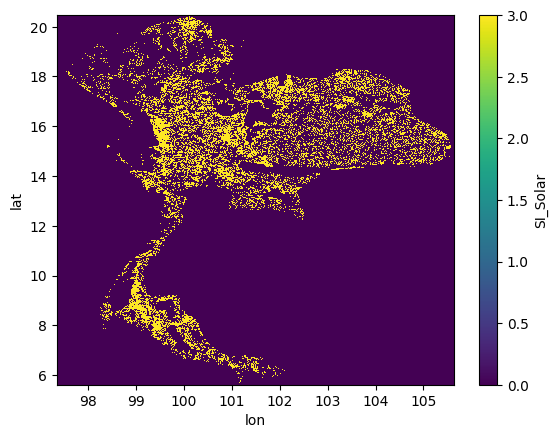

In [5]:
xr_distancetowetland['SI_Solar'].plot()

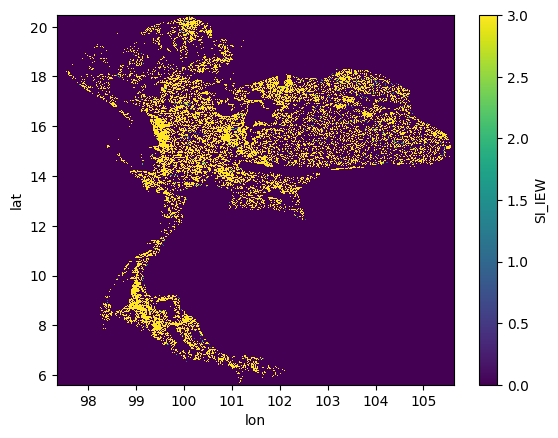

In [6]:
xr_distancetowetland['SI_IEW'].plot()